## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import json
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
df_paired_not_zero.csv  paired.csv              vdjdb.txt
df_paired_zero.csv      paired_transformed.csv  visualisations/


In [ ]:
%cd drive/MyDrive/vdjdb

[Errno 2] No such file or directory: 'drive/MyDrive/vdjdb'
/content/drive/MyDrive/vdjdb


# **Example 2: Train & Test Datasets**
#### Train classifier on a train dataset, then test on another, independent test dataset.
The datasets used were downloaded from https://github.com/IdoSpringer/ERGO-II/tree/master/Samples. These are pickle files (vdjdb_no10x_train_samples.pickle, vdjdb_no10x_test_samples.pickle), whcih can be converted into a pandas dataframes and csv files easily. For example:
```python
def load_from_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

df_train = load_from_pickle("vdjdb_no10x_train_samples.pickle")
df_train = pd.DataFrame.from_dict(df_train)
df_train.to_csv("vdjdb_no10x_train_samples.csv", index = False)
```

### Parameters

Set manually

In [ ]:
# set params
k_neighbours = 5
organism = 'human' # 'mouse' or 'human'
chains = ['alpha', 'beta'] # ['alpha', 'beta'] or ['alpha'] or ['beta']
cdrs = 'cdr3' # 'cdr3' or 'all'

validate user-inputs

In [ ]:
# make sure input config params are valid
assert organism=='mouse' or organism=='human'
assert cdrs=='all' or cdrs=='cdr3'
assert chains==['alpha', 'beta'] or chains==['beta', 'alpha'] or chains==['alpha'] or chains==['beta']

## Train

### Prepare training data

In [ ]:
%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2 -q

  Preparing metadata (setup.py) ... done


In [ ]:
import os
from tcrdist.repertoire import TCRrep
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/vdjdb/vdjdb.txt", delimiter="\t")
df.head(2)

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2,sort,sanger,no,no


In [ ]:
# Select the columns we need
selected_features = ["complex.id" ,'gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score']

df = df[selected_features]
df.head()

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2


In [ ]:
## Pairing alpha beta chains (including only non zero vdjdb score rows)

list_to_combine = []
checked_ids = []
def process_row(row, df = df):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = df[df['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            if tra_row["vdjdb.score"] + trb_row["vdjdb.score"] >= 1: ## if sum of vdjdb score of tra and trb row is more than 0, then these are joined together

                # add to list as a combined row
                list_to_combine.append({
                                        'complex.id':tra_row['complex.id'],
                                        'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                        'v_b_gene' :trb_row['v.segm'],
                                        'j_b_gene':trb_row['j.segm'],
                                        'v_a_gene':tra_row['v.segm'],
                                        'j_a_gene':tra_row['j.segm'],
                                        "mhc.a" : tra_row["mhc.a"],
                                        "mhc.b" : tra_row["mhc.b"],
                                        "antigen.species" : tra_row["antigen.species"],
                                        'antigen.epitope': tra_row['antigen.epitope'],
                                        'vdjdb.score': max(tra_row["vdjdb.score"] , trb_row["vdjdb.score"])
                                      })
                # we've checked this id now, so we need to make sure we don't have to check it again.
                checked_ids.append(row['complex.id'])
df.apply(process_row, axis=1)
df_paired_not_zero = pd.DataFrame(list_to_combine)
df_paired_not_zero.head()

,complex.id,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,mhc.a,mhc.b,antigen.species,antigen.epitope,vdjdb.score
0,1,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,HIV-1,FLKEKGGL,2
1,2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,HLA-B*08,B2M,HIV-1,FLKEKGGL,2
2,3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV2*01,NaN,HLA-B*08,B2M,HIV-1,FLKEKGGL,2
3,4,CAYRPPGTYKYIF,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,TRAV38-2/DV8*01,TRAJ40*01,HLA-B*08,B2M,HIV-1,FLKEKGGL,2
4,5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,HLA-B*08,B2M,HIV-1,FLKEQGGL,2


In [ ]:
## Pairing alpha beta chains (including only zero vdjdb score rows)

list_to_combine = []
checked_ids = []
def process_row(row, df = df):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = df[df['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            if tra_row["vdjdb.score"] + trb_row["vdjdb.score"] == 0:

                # add to list as a combined row
                list_to_combine.append({
                                        'complex.id':tra_row['complex.id'],
                                        'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                        'v_b_gene' :trb_row['v.segm'],
                                        'j_b_gene':trb_row['j.segm'],
                                        'v_a_gene':tra_row['v.segm'],
                                        'j_a_gene':tra_row['j.segm'],
                                        "mhc.a" : tra_row["mhc.a"],
                                        "mhc.b" : tra_row["mhc.b"],
                                        "antigen.species" : tra_row["antigen.species"],
                                        'antigen.epitope': tra_row['antigen.epitope'],
                                        'vdjdb.score': max(tra_row["vdjdb.score"] , trb_row["vdjdb.score"])
                                      })
                # we've checked this id now, so we need to make sure we don't have to check it again.
                checked_ids.append(row['complex.id'])
df.apply(process_row, axis=1)
df_paired_zero = pd.DataFrame(list_to_combine)
df_paired_zero.head()

In [ ]:
# Write df_paired_not_zero to CSV
df_paired_not_zero.to_csv("df_paired_not_zero.csv", index=False)

# Write df_paired_zero to CSV
df_paired_zero.to_csv("df_paired_zero.csv", index=False)

In [ ]:
# # get col names to consider for dropping duplicate TCRs
# drop_dup_cols = ['antigen.epitope']

# # add alpha chain col names
# if 'alpha' in chains and cdrs=='cdr3':
#     drop_dup_cols += ['cdr3_a_aa']
# elif 'alpha' in chains and cdrs=='all':
#     drop_dup_cols += ['cdr3_a_aa', 'v_a_gene', 'j_a_gene']

# # add beta chain col names
# if 'beta' in chains and cdrs=='cdr3':
#     drop_dup_cols += ['cdr3_b_aa']
# elif 'beta' in chains and cdrs=='all':
#     drop_dup_cols += ['cdr3_b_aa', 'v_b_gene', 'j_b_gene']

In [ ]:
# drop_dup_cols = ['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene']
# df_after_drop_dup = df.drop_duplicates(subset=drop_dup_cols, keep='first').copy()
# df_after_drop_dup.reset_index(drop=True, inplace=True)

# # print(f'Dropped {n_orig - df_train.shape[0]} duplicate TCRs by columns {drop_dup_cols}.')
# print(f'The new amount of TCRs per epitope:\n')
# df_after_drop_dup['antigen.epitope'].value_counts()

In [ ]:
# df_after_drop_dup.shape

In [ ]:
import pandas as pd

# Reading the CSV files
df_paired_not_zero = pd.read_csv("df_paired_not_zero.csv")
df_paired_zero = pd.read_csv("df_paired_zero.csv")

# Printing the shapes of both DataFrames
print("Shape of df_paired_not_zero:", df_paired_not_zero.shape)
print("Shape of df_paired_zero:", df_paired_zero.shape)


Shape of df_paired_not_zero: (2965, 12)
Shape of df_paired_zero: (27629, 12)


In [ ]:
# Finding the frequency of epitiopes with vdjdb score more than 0

df_paired_not_zero['antigen.epitope'].value_counts()[:10]

antigen.epitope
NLVPMVATV         461
SSYRRPVGI         261
GILGFVFTL         250
ASNENMETM         136
SSLENFRAYV        130
SSPPMFRV          106
HGIRNASFI         102
TFEYVSQPFLMDLE     87
GLCTLVAML          72
RPRGEVRFL          68
Name: count, dtype: int64

- An attempt was made to train the model using the above frequency, vdjdb score > 0.
- However the TCRdist library would consistently remove duplicates/frequently occurring epitopes which reduced the dataset size.

In [ ]:

epitopes = df_paired_not_zero['antigen.epitope'].value_counts()[:10].index.to_list()
## Creating new dataset with only top 10 epitopes
df_paired_zero_filtered = df_paired_zero[df_paired_zero["antigen.epitope"].isin(epitopes)] # Including only top 10 epitopes illustrated above
df_paired_not_zero_filtered = df_paired_not_zero[df_paired_not_zero["antigen.epitope"].isin(epitopes)] # # Including only top 10 epitopes illustrated above

print("Shape of df_paired_zero_filtered:")
print(df_paired_zero_filtered.shape)

print("Shape of df_paired_not_zero_filtered:")
print(df_paired_not_zero_filtered.shape)


Shape of df_paired_zero_filtered:
(3863, 12)
Shape of df_paired_not_zero_filtered:
(1673, 12)


In [ ]:
df_top10 = pd.concat([df_paired_zero_filtered, df_paired_not_zero_filtered])
df_top10.shape

(5536, 12)

In [ ]:
#after joining
df_top10["antigen.epitope"].value_counts()

antigen.epitope
GILGFVFTL         2194
SSYRRPVGI          661
NLVPMVATV          588
SSLENFRAYV         437
TFEYVSQPFLMDLE     411
GLCTLVAML          394
ASNENMETM          325
HGIRNASFI          288
SSPPMFRV           163
RPRGEVRFL           75
Name: count, dtype: int64

In [ ]:
# Before Joining
df_paired_not_zero['antigen.epitope'].value_counts()[:10]

antigen.epitope
NLVPMVATV         461
SSYRRPVGI         261
GILGFVFTL         250
ASNENMETM         136
SSLENFRAYV        130
SSPPMFRV          106
HGIRNASFI         102
TFEYVSQPFLMDLE     87
GLCTLVAML          72
RPRGEVRFL          68
Name: count, dtype: int64

In [ ]:
df_top10.fillna("missing", inplace = True)

In [ ]:
df_top10.isnull().sum()

complex.id         0
cdr3_a_aa          0
cdr3_b_aa          0
v_b_gene           0
j_b_gene           0
v_a_gene           0
j_a_gene           0
mhc.a              0
mhc.b              0
antigen.species    0
antigen.epitope    0
vdjdb.score        0
dtype: int64

In [ ]:
# def print_num_epitopes(df , threshold):

#     freq_count = df["antigen.epitope"].value_counts()

#     print(f"""Epitopes having less than {threshold} datapoints:  {freq_count[freq_count<threshold].shape[0]}""")

#     print(f"""Epitopes having more than {threshold} datapoints:  {df["antigen.epitope"].nunique() - freq_count[freq_count<threshold].shape[0]}""")
# pd.concat()
# print_num_epitopes(df, 60)

In [ ]:


# def filter_data(N, df):

#     freq_count = df["antigen.epitope"].value_counts()
#     antigen_epitopes = []
#     for antigen_epitope in freq_count[freq_count>N].index:
#       antigen_epitope_df = df[df["antigen.epitope"] == antigen_epitope][:N]

#       antigen_epitopes.append(antigen_epitope_df)

#     df = pd.concat(antigen_epitopes)
#     return df


# df = filter_data(350, df)
# df["antigen.epitope"].value_counts()

In [ ]:
# epitope_top10 = list(df_after_drop_dup["antigen.epitope"].value_counts()[:10].index)
# df_top10 = df_after_drop_dup[df_after_drop_dup["antigen.epitope"].isin(epitope_top10)].reset_index(drop = True)
# df_top10.head()

In [ ]:
# df_train_list, df_test_list = [], []
# N = 350
# n_train, n_test = int(N*0.80),  int(N*0.20)
# # n_train, n_test = 3640, 910

# for antigen_epitope in df["antigen.epitope"].unique():
#     train = df[df["antigen.epitope"] == antigen_epitope][:n_train]
#     test = df[df["antigen.epitope"] == antigen_epitope][n_train:]

#     df_train_list.append(train)
#     df_test_list.append(test)

# df_train = pd.concat(df_train_list)
# df_test = pd.concat(df_test_list)
# print("df_train.shape: ",df_train.shape[0])
# print("df_test.shape: ",df_test.shape[0])
# df_top10.columns

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_top10 = df_top10[['cdr3_a_aa', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'v_a_gene', 'j_a_gene', 'antigen.epitope']]

# Assuming 'target_column' is the name of your target column
X = df_top10.drop(columns=['antigen.epitope'])  # Features
y = df_top10['antigen.epitope']  # Target variable

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)




In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# from imblearn.over_sampling import SMOTE

# # Apply one-hot encoding to categorical columns
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# X_train_encoded = encoder.fit_transform(X_train.values)  # Assuming last 3 columns are categorical

# # Apply SMOTE to balance the data
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_encoded, y_train)

# # Inverse transform the one-hot encoded data to get the original data back
# X_resampled_original = pd.DataFrame(encoder.inverse_transform(X_resampled), columns = ['cdr3_a_aa', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'v_a_gene', 'j_a_gene'] )
# X_resampled_original = encoder.inverse_transform(X_resampled)

In [ ]:
# Merging X_train and y_train
df_train = pd.concat([X_train, y_train], axis=1)

# Merging X_test and y_test
df_test = pd.concat([X_test, y_test], axis=1)


print("df_train.shape:", df_train.shape)
print("df_test.shape:", df_test.shape)

df_train.shape: (3709, 7)
df_test.shape: (1827, 7)


Drop duplicate TCRs for each epitope *separately*

In [ ]:
n_orig = df_train.shape[0]
print(f'The dataset contains {df_train.shape[0]} TCRs for {len(df_train["antigen.epitope"].unique())} different epitopes\n')

The dataset contains 3709 TCRs for 10 different epitopes



In [ ]:
# df_test["antigen.epitope"].nunique()
df_train["antigen.epitope"].nunique()

10

### Get tcrdist distances for training data

*If asked to use all cdrs to compute tcrdist distances, can compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [ ]:
# set params
k_neighbours = 5
organism = 'human' # 'mouse' or 'human'
chains = ['alpha', 'beta'] # ['alpha', 'beta'] or ['alpha'] or ['beta']
cdrs = 'all' # 'cdr3' or 'all'

In [ ]:
# df_train

In [ ]:
from tcrdist.repertoire import TCRrep
# df_train = df_train.sample(frac = 1) # shuffle


tr = TCRrep(cell_df=df_train,
            chains = chains,
            organism=organism,
            deduplicate=True
            ) # This step will remove any TCRs where we could not infer genes

# <X> will be our matrix of distances, which will depend on <chains> and <cdrs>
X = None
if cdrs=='all':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_alpha + tr.pw_beta)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_alpha)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_beta)
if cdrs=='cdr3':
    if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa)
    elif chains==['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa)
    elif chains==['beta']:
        X = pd.DataFrame(tr.pw_cdr3_b_aa)

assert X is not None

In [ ]:
# pd.DataFrame(tr.pw_alpha + tr.pw_beta)
# (tr.pw_alpha + tr.pw_beta)

# tr.pw_beta.shape

In [ ]:
X.shape

(2210, 2210)

In [ ]:
## Before creating tcrdist matrix
df_train["antigen.epitope"].value_counts()

antigen.epitope
GILGFVFTL         1444
SSYRRPVGI          465
NLVPMVATV          386
SSLENFRAYV         299
GLCTLVAML          269
TFEYVSQPFLMDLE     263
ASNENMETM          218
HGIRNASFI          193
SSPPMFRV           118
RPRGEVRFL           54
Name: count, dtype: int64

In [ ]:
# after Creating tcrdist matrix (Number of rows has decreased)
Y = pd.DataFrame(tr.clone_df['antigen.epitope']) # training data labels
Y.value_counts()

antigen.epitope
GILGFVFTL          1310
NLVPMVATV           315
TFEYVSQPFLMDLE      260
GLCTLVAML           246
RPRGEVRFL            39
SSPPMFRV             14
SSLENFRAYV            9
SSYRRPVGI             8
HGIRNASFI             7
ASNENMETM             2
Name: count, dtype: int64

In [ ]:
# Make sure X and Y are valid
assert X.shape[0] == X.shape[1], f'assert X shape is nXn: {X.shape[0]} == {X.shape[1]} ?'
#assert X.shape[0] == df_train.shape[0], f'assert X dimension equals df_train dimension: {X.shape[0]} == {df_train.shape[0]} ?'
assert X.shape[0] == Y.shape[0],  f'assert Y length = n: {X.shape[0]} == {Y.shape[0]} ?'

X.index = list(X.index) # change from range to int
Y.index = list(Y.index) # change from range to int
assert (X.index.equals(Y.index)), f'assert X and Y indices are equal'

### Train KNN model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from matplotlib.patches import Rectangle



In [ ]:
# train model on entire train set
model = KNeighborsClassifier(n_neighbors=k_neighbours, metric='precomputed', weights='distance')
model.fit(X, Y.values.ravel())

KNeighborsClassifier(metric='precomputed', weights='distance')

## Test

### Prepare test data

Keep only TCRs that have CDR3a and CDR3b, specific to epitope presented on MHC class 1, specifically HLA-A*02

In [ ]:
df_test.head()

,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,antigen.epitope
2643,CAVRGTNARLMF,CASSVVTEAFF,TRBV12-3*01,TRBJ1-1*01,TRAV3*01,TRAJ31*01,NLVPMVATV
6004,CAVSLGGGSQGNLIF,CASSIRSTDTQYF,TRBV19*01,TRBJ2-3*01,TRAV12-2*01,TRAJ42*01,GILGFVFTL
22162,CAESSRGKLIF,CSVGTGGTNEKLFF,TRBV29-1*01,TRBJ1-4*01,TRAV5*01,TRAJ37*01,GLCTLVAML
610,LKENTGFQKLVF,CASSGTGAGEQYF,TRBV19*01,TRBJ2-7*01,TRAV8-1*01,TRAJ8*01,GILGFVFTL
1714,CAGGGSQGNLIF,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,TRAV27*01,TRAJ42*01,GILGFVFTL


In [ ]:
df_test["antigen.epitope"].value_counts()

antigen.epitope
GILGFVFTL         750
NLVPMVATV         202
SSYRRPVGI         196
TFEYVSQPFLMDLE    148
SSLENFRAYV        138
GLCTLVAML         125
ASNENMETM         107
HGIRNASFI          95
SSPPMFRV           45
RPRGEVRFL          21
Name: count, dtype: int64

Keep only epitopes included in the train set

In [ ]:
peptide_list = list(df_train['antigen.epitope'].unique())
df_test = df_test.loc[df_test['antigen.epitope'].isin(peptide_list)]
df_test.reset_index(drop=True, inplace=True)

In [ ]:
# peptide_list
# df_test["antigen.epitope"].unique()

### Get tcrdist distances between test TCRs and train TCRs
*If asked to use all cdrs to compute tcrdist distances, compute it when TCRrep object is initialized. If asked to use only CDR3, the TCRrep object metric parameters need to be altered before computing the distances.

In [ ]:
tcrrep_test = TCRrep(cell_df=df_test,
                     organism=organism,
                     chains=chains,
                     deduplicate=True)

tcrrep_test.compute_rect_distances(df=tcrrep_test.clone_df,
                                    df2=tr.clone_df)

Get distances matrix (X_test) between test and train TCRs

In [ ]:
if cdrs=='all':
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha + tcrrep_test.rw_beta)
  elif chains==['alpha']:
      X_test = pd.DataFrame(tcrrep_test.rw_alpha)
  elif chains==['beta']:
      X_test = pd.DataFrame(tcrrep_test.rw_beta)

if cdrs == "cdr3":
  if chains==['alpha', 'beta'] or chains==['beta', 'alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa + tcrrep_test.rw_cdr3_b_aa)
  elif chains==['alpha']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_a_aa)
  elif chains==['beta']:
        X_test = pd.DataFrame(tcrrep_test.rw_cdr3_b_aa)

In [ ]:
# assert dimensions are n_test X n_train
# assert X_test.shape[0] == df_test.shape[0], f'assert X_test rows dimension equals df_test dimension: {X_test.shape[0]} == {df_test.shape[0]} ?'
assert X_test.shape[1] == X.shape[0], f'assert X columns dimension equals X(train) dimension: {X.shape[0]} == {df_train.shape[0]} ?'

In [ ]:
# Before creating tcrdist matrix
df_test["antigen.epitope"].value_counts()

antigen.epitope
GILGFVFTL         750
NLVPMVATV         202
SSYRRPVGI         196
TFEYVSQPFLMDLE    148
SSLENFRAYV        138
GLCTLVAML         125
ASNENMETM         107
HGIRNASFI          95
SSPPMFRV           45
RPRGEVRFL          21
Name: count, dtype: int64

In [ ]:
# After creating tcrdist matrix
tcrrep_test.clone_df["antigen.epitope"].value_counts()

antigen.epitope
GILGFVFTL         710
NLVPMVATV         181
TFEYVSQPFLMDLE    147
GLCTLVAML         124
RPRGEVRFL          19
HGIRNASFI           7
SSLENFRAYV          4
SSYRRPVGI           3
SSPPMFRV            1
ASNENMETM           1
Name: count, dtype: int64

In [ ]:
# get predictions
preds_prob = model.predict_proba(X_test)
preds_labels = model.predict(X_test)

# get test data labels
Y_test = tcrrep_test.clone_df['antigen.epitope']

In [ ]:
Y_test.unique()

array(['GILGFVFTL', 'GLCTLVAML', 'NLVPMVATV', 'HGIRNASFI', 'SSPPMFRV',
       'SSYRRPVGI', 'TFEYVSQPFLMDLE', 'SSLENFRAYV', 'RPRGEVRFL',
       'ASNENMETM'], dtype=object)

### Plot results

Calculate performance metrics

In [ ]:
metrics = {}
metrics['accuracy'] = accuracy_score(Y_test, preds_labels)
metrics['roc_auc'] = roc_auc_score(Y_test, pd.DataFrame(preds_prob, columns=model.classes_), average='macro', multi_class='ovr')

metrics['confusion_matrix'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels), columns=model.classes_, index=model.classes_)
metrics['confusion_matrix_norm'] = pd.DataFrame(confusion_matrix(Y_test, preds_labels, normalize='true'), columns=model.classes_, index=model.classes_)

metrics_df = pd.DataFrame(columns=model.classes_)
metrics_df.loc['precision'] = precision_score(Y_test, preds_labels, average=None)
metrics_df.loc['recall'] = recall_score(Y_test, preds_labels, average=None)
metrics_df.loc['f1'] = f1_score(Y_test, preds_labels, average=None)

In [ ]:
metrics_df.T

,precision,recall,f1
ASNENMETM,0.000000,0.000000,0.000000
GILGFVFTL,0.921703,0.945070,0.933241
GLCTLVAML,0.811024,0.830645,0.820717
HGIRNASFI,1.000000,0.285714,0.444444
NLVPMVATV,0.819767,0.779006,0.798867
RPRGEVRFL,1.000000,0.842105,0.914286
SSLENFRAYV,0.500000,0.250000,0.333333
SSPPMFRV,0.500000,1.000000,0.666667
SSYRRPVGI,0.285714,0.666667,0.400000
TFEYVSQPFLMDLE,0.992908,0.952381,0.972222


Plot confusion matrix

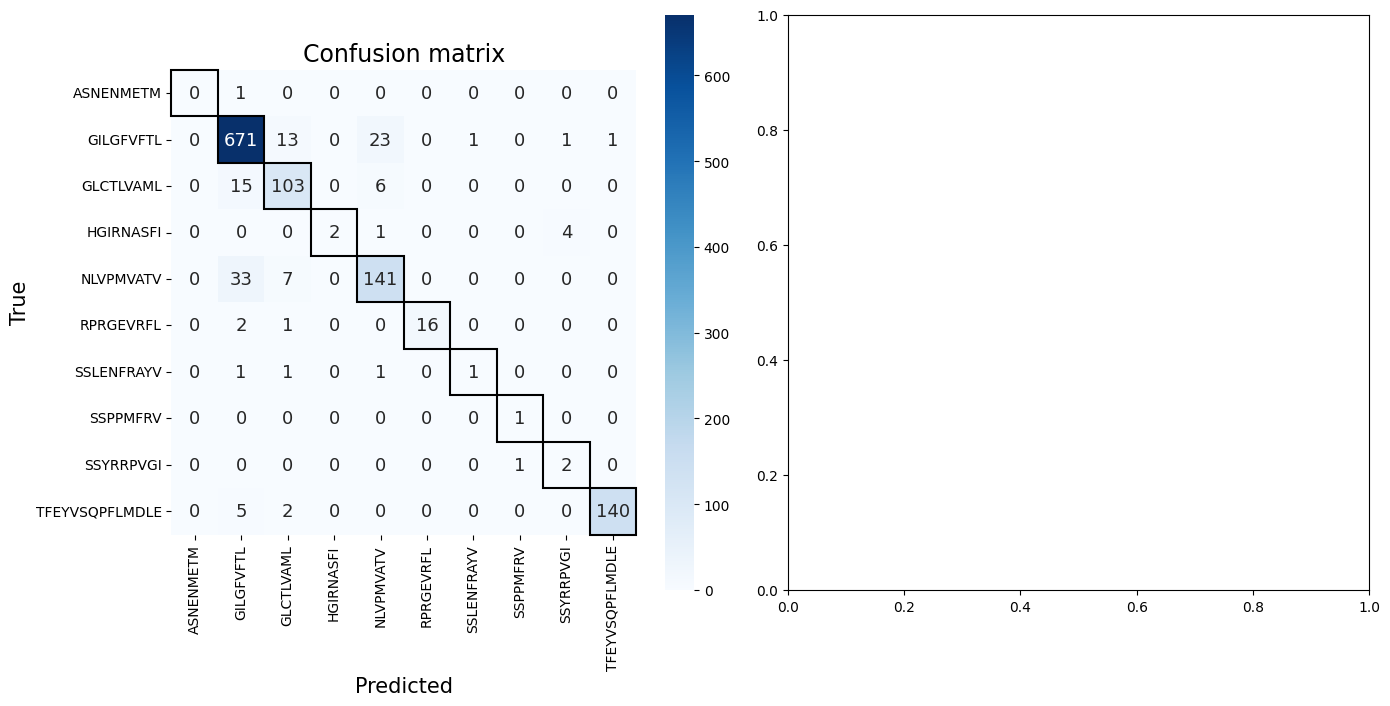

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
sns.set_context(font_scale=1.1)
sns.heatmap(metrics['confusion_matrix'], annot=True, cmap='Blues', fmt='', ax=axes[0], square=True, annot_kws={"size": 13})
axes[0].set_xlabel('Predicted', fontsize=15)
axes[0].set_ylabel('True', fontsize=15)
axes[0].set_title('Confusion matrix', fontsize=17)
for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)

# sns.heatmap(metrics['confusion_matrix_norm'], annot=True, cmap='Greens', fmt='.2f', ax=axes[1], square=True, annot_kws={"size": 13})
# axes[1].set_title('Confusion matrix, normalized', fontsize=17)
# axes[1].set_xlabel('Predicted', fontsize=5)
# axes[1].set_ylabel('True', fontsize=5)
# for tick in axes[1].get_xticklabels():
#         tick.set_rotation(90)

for epi_ind in range(metrics['confusion_matrix'].shape[0]):
    axes[0].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    # axes[1].add_patch(Rectangle((epi_ind, epi_ind), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))

plt.tight_layout()

Plot metrics (per epitope)

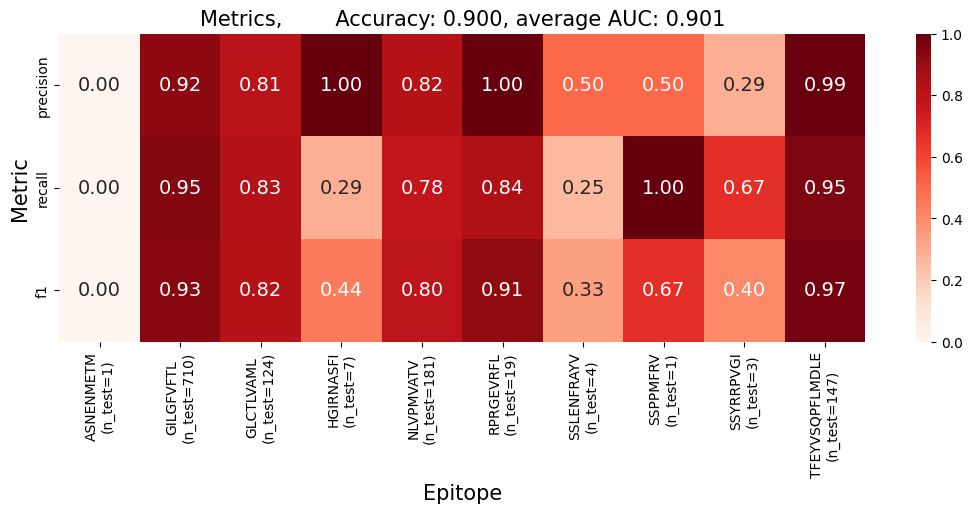

In [ ]:
plt.figure(figsize=(13,4))
ax = sns.heatmap(metrics_df, annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 14}, vmin=0, vmax=1)
ax.set_ylabel('Metric', fontsize=15)
ax.set_xlabel('Epitope', fontsize=15)
ax.set_title(f"Metrics,        Accuracy: {metrics['accuracy']:.3f}, average AUC: {metrics['roc_auc']:.3f}", fontsize=15)
_ = ax.set_xticklabels([epi + f'\n(n_test={(Y_test==epi).sum()})' for epi in metrics_df.columns])


Plot ROC curves

In [ ]:
Y_matrix = pd.get_dummies(tcrrep_test.clone_df['antigen.epitope'])
colors = ['red', 'dodgerblue', 'darkviolet', 'lightgreen', 'darkorange', 'mediumblue', 'maroon', 'teal', 'purple', 'green', 'deepskyblue', 'yellowgreen', 'lightcoral', 'gold', ]

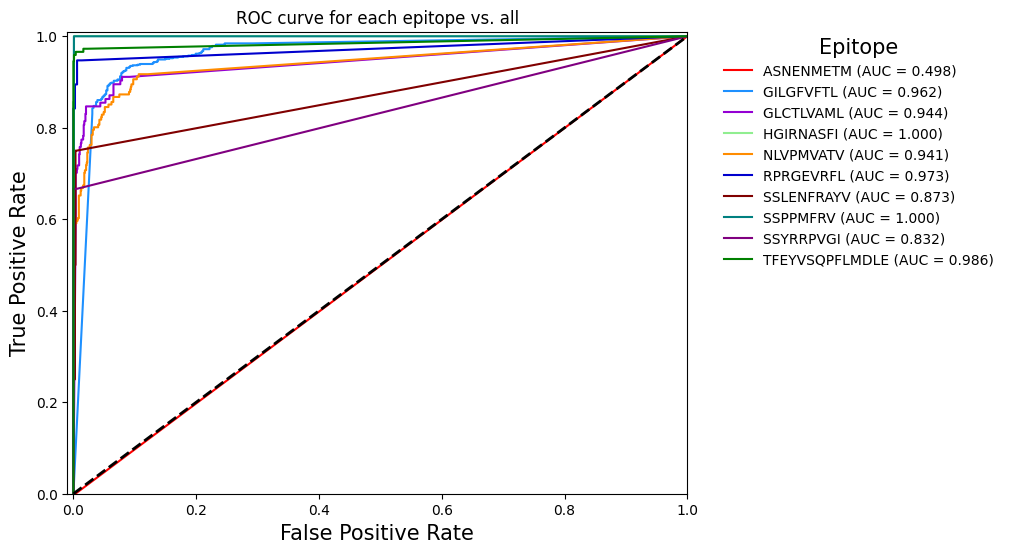

In [ ]:
# Get ROC curve info for each epitope
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, ep in enumerate(model.classes_):
    fpr[ep], tpr[ep], _ = roc_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    roc_auc[ep] = auc(fpr[ep], tpr[ep])

# Plot ROC curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(fpr[ep], tpr[ep], color=color, lw=1.5, label=f'{ep} (AUC = {roc_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)

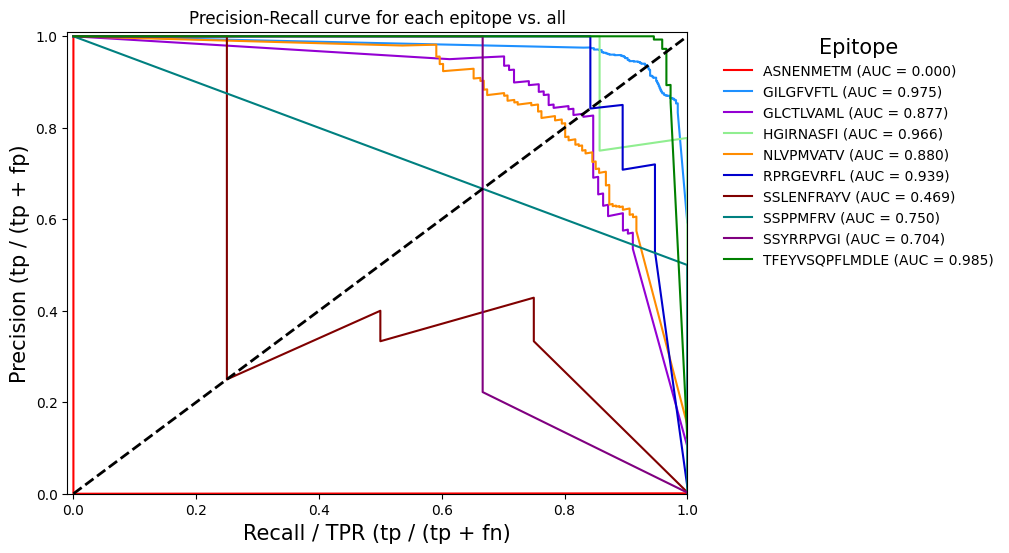

In [185]:
from sklearn.metrics import precision_recall_curve

# Get precision_recall curve info for each epitope
precision_cur = dict()
recall_cur = dict()
pre_rec_auc = dict()
for i, ep in enumerate(model.classes_):
    precision_cur[ep], recall_cur[ep], _ = precision_recall_curve(Y_matrix.loc[:, ep], preds_prob[:, i])
    pre_rec_auc[ep] = auc(recall_cur[ep], precision_cur[ep])

# Plot precision_recall curves
fig, ax = plt.subplots(figsize=(8, 6))
for ep, color in zip(model.classes_, colors):
    ax.plot(recall_cur[ep], precision_cur[ep], color=color, lw=1.5, label=f'{ep} (AUC = {pre_rec_auc[ep]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall / TPR (tp / (tp + fn)', fontsize=15)
plt.ylabel('Precision (tp / (tp + fp)', fontsize=15)
plt.title('Precision-Recall curve for each epitope vs. all')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False, title='Epitope')
_ = plt.setp(ax.get_legend().get_title(), fontsize=15)

## Trying Other Models

In [ ]:
from utils import evaluate_models
from sklearn.ensemble import (
    # AdaBoostClassifier,
    # GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier

In [ ]:
Y.values.ravel()

array(['ELAGIGILTV', 'ELAGIGILTV', 'ELAGIGILTV', ..., 'TFEYVSQPFLMDLE',
       'TFEYVSQPFLMDLE', 'TFEYVSQPFLMDLE'], dtype=object)

In [ ]:


models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    # "XGBClassifier": XGBClassifier(),
#     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    # "AdaBoost Classifier": AdaBoostClassifier(),
}

params = {
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        # 'splitter':['best','random'],
        # 'max_features':['sqrt','log2'],
    },
    "Random Forest": {
        'n_estimators': [8, 16, 32]
    },
    # "Gradient Boosting": {
    #     'learning_rate': [.1, 0.005,],
    #     'subsample': [0.6, 0.7],
    #     'n_estimators': [8, 16, 32]
    # },
    "Logistic Regression": {},
    # "XGBClassifier": {
    #     'learning_rate': [.1, .01, .05],
    #     'n_estimators': [8, 16, 32, ]
    # },
#     "CatBoosting Classifier": {
#         'depth': [6, 8, 10],
#         'learning_rate': [0.01, 0.05, 0.1],
#         'iterations': [30, 50, 100]
#     },
    # "AdaBoost Classifier": {
    #     'learning_rate': [.1, .01, .001],
    #     'n_estimators': [8, 16, 32, ]
    # }
}

model_report: dict = evaluate_models(X_train=X, y_train=Y.values.ravel(), X_test=X_test, y_test=Y_test,
                                      models=models, param=params)


Model: RandomForestClassifier()
Parameters: {'n_estimators': [8, 16, 32]}
Model: DecisionTreeClassifier()
Parameters: {'criterion': ['gini', 'entropy']}
Model: LogisticRegression()
Parameters: {}


In [ ]:
print(model_report)